In [1]:
import warnings
warnings.filterwarnings(action='ignore')

# Chapter 3 분류

## 3.1 MNIST

#### 사이킷런에서 읽어 들인 데이터 셋 딕셔너리 구조

In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [3]:
X, y = mnist['data'], mnist['target']
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


#### 데이터셋에서 이미지 확인하기

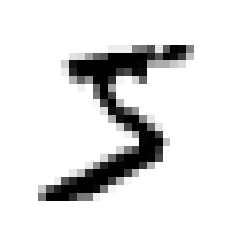

In [4]:
import matplotlib as mpl
import matplotlib .pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap="binary" )
plt.axis("off")
plt.show()

In [5]:
import numpy as np

print(y[0])
print(type(y[0]))
y = y.astype(np.uint8)
print(type(y[0]))

5
<class 'str'>
<class 'numpy.uint8'>


#### 훈련 테스트 데이터 나누기

In [6]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:] 

## 3.2 이진 분류기 훈련

In [7]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [8]:
#사이컷런의 SGDClassifier를 사용한 확률적 경사 하강법 분류기(SGD)
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=22)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=22)

[ True]


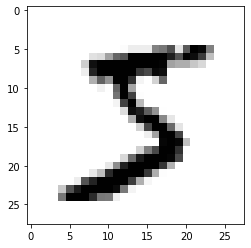

In [9]:
#sgd 모델을 사용한 숫자 5 이미지 감지
print(sgd_clf.predict([some_digit]))
plt.imshow(some_digit_image, cmap='binary')
plt.show()

## 3.3 성능 측정

### 3.3.1 교차 검증을 사용한 정확도 측정

In [10]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=11)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred), end = ' ')

0.9679 0.964 0.9542 

In [11]:
# cross_val_score() 함수로 폴드가 3개인 k-겹 교차 검증
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy") 

array([0.9679, 0.964 , 0.9542])

#### 모든 이미지를 5아님 클래스로 분류하는 더미 분류기 만들기

In [12]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.91125, 0.90855, 0.90915])

### 3.3.2 오차 행렬

In [13]:
# 실제 타깃과 비교할 수 있는 예측값 만들기
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3) 

In [14]:
# 오차 행렬 만들기
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[54149,   430],
       [ 1848,  3573]], dtype=int64)

### 3.3.3 정밀도와 재현율

In [15]:
# 정밀도와 재현율
from sklearn.metrics import precision_score, recall_score

print(precision_score(y_train_5, y_train_pred))
print(recall_score(y_train_5, y_train_pred))

0.8925805645765675
0.659103486441616


In [16]:
# F1 score
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.758276740237691

### 3.3.4 정밀도/재현율 트레이드오프

In [17]:
# decision_function() 메서드를 호출하면 각 샘플의 점수를 얻을 수 있다.
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([3875.06838355])

In [18]:
# 임곗값이 0이므로, true를 반환한다.
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [19]:
# 임곗값이 높이면 false를 반환한다.
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [20]:
# cross_val_predict()로 훈련 세트에 있는 모든 샘플의 점수 구하기
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function" )

In [21]:
# precision_recall_curve() 함수를 사용하여 모든 임곗값에 대한 정밀도와 재현율 계산
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

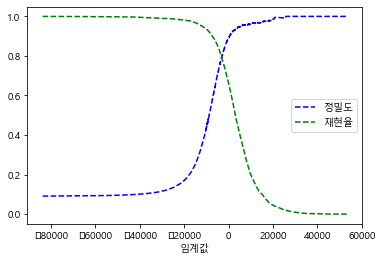

In [22]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
fm.get_fontconfig_fonts()
font_location = "c:/Windows/Fonts/malgun.ttf"
font_name = fm.FontProperties(fname=font_location).get_name()
plt.rc('font', family=font_name)
%matplotlib inline


def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="정밀도")
    plt.plot(thresholds, recalls[:-1], "g--", label="재현율")
    plt.xlabel("임계값")
    plt.legend()


plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

#### 정밀도 90% 달성하기

In [23]:
# 최소한 90% 정밀도가 되는 가장 낮은 임곗값 찾기
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
# 예측 만들기
y_train_pred_90 = (y_scores >= threshold_90_precision) 

# 예측에 대한 정밀도와 재현율 확인
print(precision_score(y_train_5, y_train_pred_90))
print(recall_score(y_train_5, y_train_pred_90))

0.9001564129301356
0.636967349197565


### 3.3.5 ROC 곡선

In [24]:
# roc_curve()함수를 사용해 여러 임곗값에서 TPR과 FPR을 계산
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

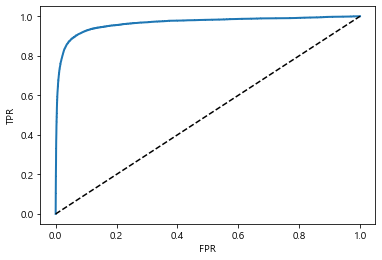

In [25]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    #대각점선
    plt.plot([0.,1], [0, 1], 'k--')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
plot_roc_curve(fpr, tpr)
plt.show()

In [26]:
# AUC 계산하는 함수
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.965116163330197

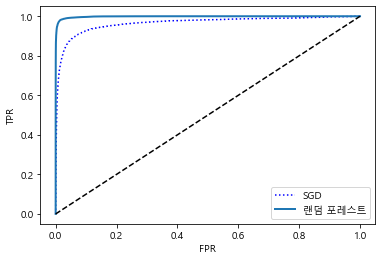

In [27]:
#RandomForestClassifier() : 랜덤분류기는 훈련 데이터의 클래스 비율을 따라 무작위로 예측
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                   method="predict_proba")

y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

plt.plot(fpr, tpr, "b:", label = "SGD")
plot_roc_curve(fpr_forest, tpr_forest, "랜덤 포레스트")
plt.legend(loc='best')
plt.show()

In [28]:
# RandomForestClassifier ROC AUC 점수
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

## 3.4 다중 분류

In [29]:
# 서포트 벡터 머신 분류기
from sklearn.svm import SVC
svm_clf = SVC()
svm_clf.fit(X_train, y_train)
svm_clf.predict([some_digit])

array([5], dtype=uint8)

In [30]:
# 클래스별 결정 점수 확인
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

In [31]:
print(np.argmax(some_digit_scores))
print(svm_clf.classes_)
print(svm_clf.classes_[5])

5
[0 1 2 3 4 5 6 7 8 9]
5


In [32]:
# SVC 기반으로 OvR전략을 사용하는 다중 분류기
from sklearn.multiclass import OneVsOneClassifier

ovo_clf = OneVsOneClassifier(SGDClassifier(max_iter=5, random_state=42))
ovo_clf.fit(X_train, y_train)
print(ovo_clf.predict([some_digit]))
print(len(ovo_clf.estimators_))

[5]
45


In [33]:
# SGDClassifier 훈련시키기
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([5], dtype=uint8)

In [34]:
# SGD 분류기가 클래스마다 부여한 점수 확인
sgd_clf.decision_function([some_digit])

array([[-15745.77017819, -29979.67273965,  -9347.92021357,
          -650.32129863, -21149.62096802,    829.16073703,
        -36713.62489686, -23754.93972255,  -6720.19812508,
        -14539.68820783]])

In [35]:
# cross_val_score()함수를 사용해 SGDClassifier의 정확도 평가
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.86855, 0.8718 , 0.8928 ])

In [36]:
# 입력의 스케일을 조정해서 정확도 높이기
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.9039 , 0.89515, 0.9034 ])

## 3.5 에러 분석

In [37]:
#cross_val_predict() 함수를 사용해 예측을 만들고
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
#confusion_matrix(0 함수를 호출해 오차 행렬 살펴보기)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5591,    0,   23,    7,    9,   51,   35,    6,  200,    1],
       [   0, 6412,   40,   23,    5,   47,    4,    8,  191,   12],
       [  26,   27, 5254,   97,   70,   28,   66,   38,  342,   10],
       [  23,   18,  122, 5252,    2,  215,   27,   41,  356,   75],
       [  10,   14,   48,   10, 5216,   12,   35,   27,  299,  171],
       [  29,   17,   32,  169,   53, 4491,   75,   16,  475,   64],
       [  28,   17,   43,    3,   45,   99, 5551,    5,  126,    1],
       [  20,   10,   53,   32,   50,   13,    3, 5709,  157,  218],
       [  17,   65,   45,   89,    3,  135,   24,   10, 5416,   47],
       [  26,   19,   30,   67,  117,   37,    1,  180,  315, 5157]],
      dtype=int64)

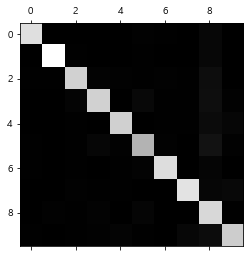

In [38]:
#matshow()을 통해 오차행렬을 이미지로 표현
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

In [39]:
#에러 비율
row_sums = conf_mx.sum(axis = 1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

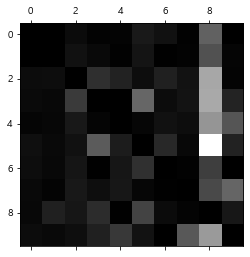

In [40]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

In [41]:
#숫자 그림을 위한 추가 함수
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.axis("off")

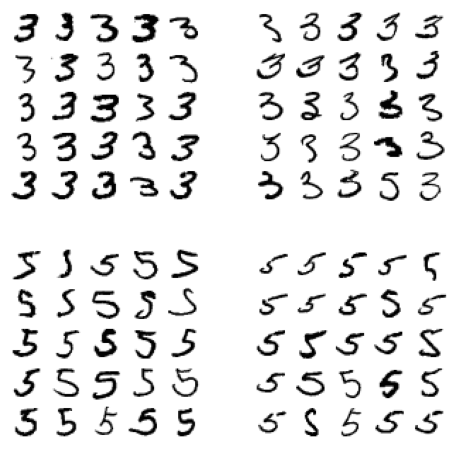

In [42]:
import matplotlib
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

## 3.6 다중 레이블 분류

In [43]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 ==1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

knn_clf.predict([some_digit])

array([[False,  True]])

In [44]:
#다중 레이블 분류기를 평가하는 방법 : F1 점수의 평균을 계산
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.976410265560605

## 3.7 다중 출력 분류

In [45]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = matplotlib.cm.binary,
               interpolation="nearest")
    plt.axis("off")

In [46]:
# MNIST 이미지에 넘파이의 randint() 함수를 사용하여 픽셀 강도에 잡음 추가
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0,100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

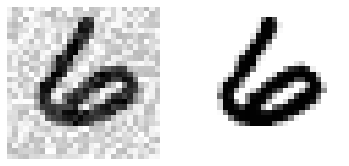

In [47]:
some_index = 5501
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])
plt.show()

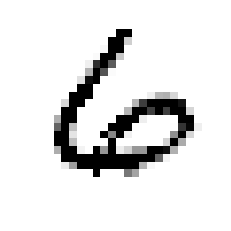

In [48]:
#잡음 제거
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)